In [30]:
import pandas as pd
import matplotlib as plt
import numpy as np 

Open and read Datas

In [31]:
path_x = "100sims_table.CSV"
path_y = "100_BE_2021.csv"

path_write = "data_processed.csv"

#Treatment of X=(X1,...Xn) Matrix Features
Data_x = pd.read_csv(path_x,skiprows=1)
Data_x = Data_x.drop('!6',axis=1)
values_to_keep =  ["VALN", "ZCB", "EQ", "RE","ILZCB","INFLN"]
Data_x =  Data_x[Data_x['CLASS'].isin(values_to_keep)].reset_index(drop=True)


#Treatment Of  Y=(Y1,....Yn) Vector Observations

Data_y = pd.read_csv("100_BE_2021.csv",sep=";")
Data_y = Data_y.dropna()
Data_y = Data_y.set_index('Sim')
Data_y.index = Data_y.index.astype(int)

Data_y['BE']



Sim
1      1794637.772
2      1531916.465
3      1415544.658
4      1412403.852
5      1560672.720
          ...     
96     1848908.378
97     1572966.354
98     1528338.086
99     1542403.764
100    1582832.262
Name: BE, Length: 100, dtype: float64

Data change format

<Axes: xlabel='Sim'>

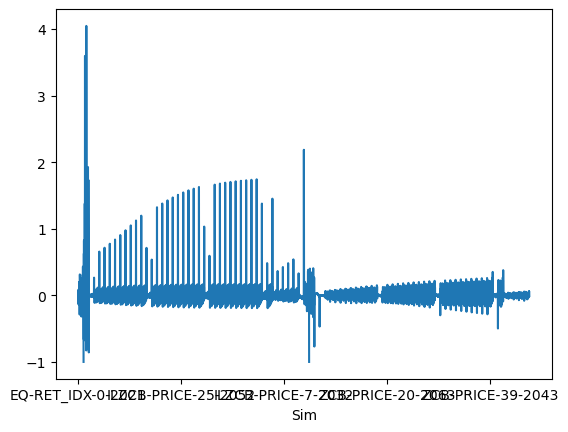

In [32]:
df = Data_x

df_melted = df.melt(id_vars=['SIMULATION', 'ECONOMY', 'CLASS', 'MEASURE', 'TERM'], 
                    var_name='YEAR', 
                    value_name='PRICE')

# Create the columns you want directly during melting
df_melted['Sim'] = df_melted['CLASS'].astype(str) + '-' + df_melted['MEASURE'].astype(str) + '-' + df_melted['TERM'].astype(str) + '-' + df_melted['YEAR'].astype(str)

# Pivot the data
df_pivoted = df_melted.pivot(index='SIMULATION', columns='Sim', values='PRICE')



X = df_pivoted.astype(np.float32)
Y = Data_y

returns_df = X.pct_change(axis=1) 
returns_df.iloc[0].plot()


Data Processing

In [4]:
from sklearn.preprocessing import StandardScaler , PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X = poly_features.fit_transform(X)

scaler = StandardScaler()

#normalize X
X_standardized = scaler.fit_transform(X)

#Normalize Y
Y_standardized = scaler.fit_transform(Y)





Dimensionnality Reduction : Aply PCA on X

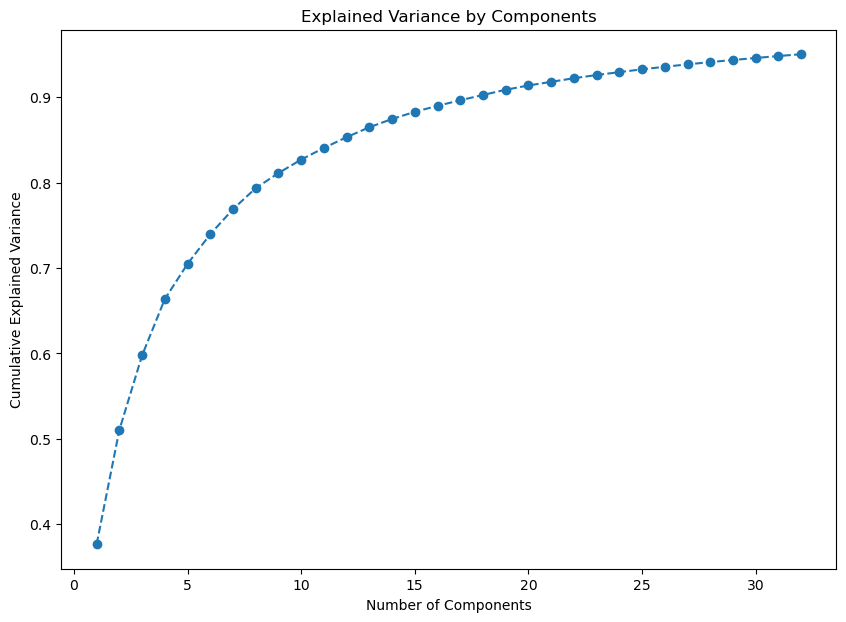

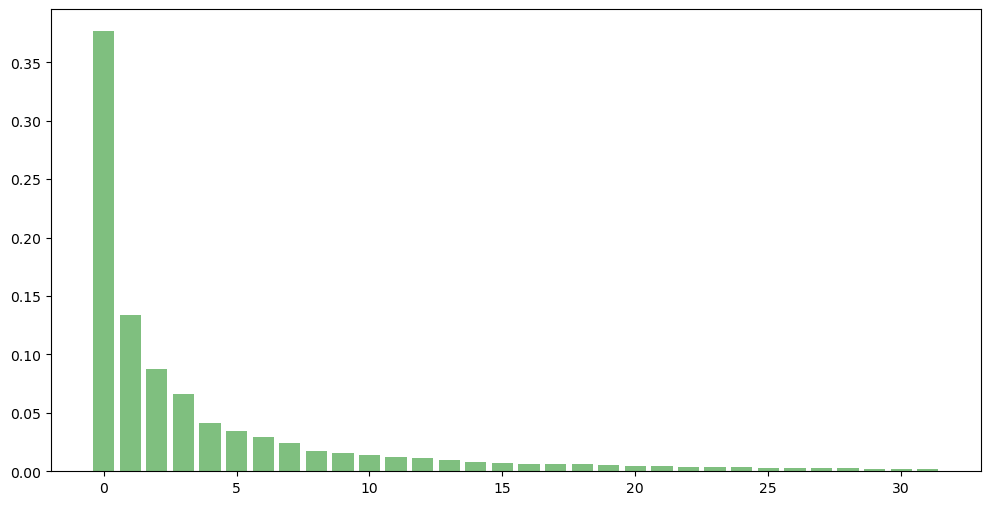

In [5]:

from sklearn.decomposition import PCA , IncrementalPCA
import matplotlib.pyplot as plt

""""n_batches = 100 
pca = IncrementalPCA()
for batch in np.array_split(X_standardized, n_batches):
    pca.partial_fit(batch)

X_standardized = pca.transform(X_standardized)"""


# 2. Apply PCA
pca = PCA(n_components=0.95)
X_standardized = pca.fit_transform(X_standardized)

# Store the results in a DataFrame
df_pca = pd.DataFrame(data = X_standardized)



plt.figure(figsize=(10, 7))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

explained_var = pca.explained_variance_ratio_
cumulative_explained_var = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(12,6))
plt.bar(range(len(explained_var)),explained_var,alpha=0.5,align='center',label="Variance Individuellle expliqué",color='g')
plt.show()

Eigenvalues Analysis of X (For objectivation of PCA)

In [ ]:

"""import numpy as np 

values , vector = np.linalg.eig(df_pca.values)
values = np.abs(values)

ratios = values/np.sum(values)
np.sort(ratios)[::-1]
somme = ratios.cumsum()
index = np.where(somme>0.95)

print(index)
print(somme[10])"""



Cross Validation to Objective Best model

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score , LeaveOneOut


lin_reg_model = LinearRegression()
loocv = LeaveOneOut()

scores = cross_val_score(lin_reg_model,X_standardized,Y_standardized,scoring="neg_mean_squared_error",cv=loocv)
lin_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    """print("Scores:", scores)"""
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
  

display_scores(scores)




Mean: -0.2620282413814205
Standard deviation: 0.4108028574019413


Learning Curve of Chosen Model

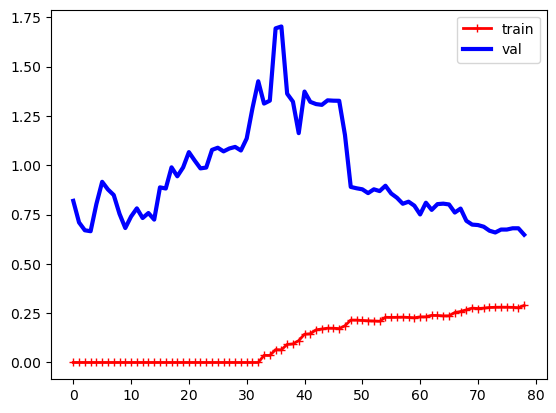

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error


lin_reg_model = LinearRegression()


def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=15)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.show()

plot_learning_curves(lin_reg_model,X_standardized, Y_standardized)


Prediction


In [29]:


X_train, X_val, y_train, y_val = train_test_split(X_standardized, Y_standardized, test_size=0.2,random_state=15)
lin_reg_model.fit(X_train,y_train)
y_pred = lin_reg_model.predict(X_val)

y_pred = scaler.inverse_transform(y_pred)
y_val = scaler.inverse_transform(y_val)

print(f" valeur moyenne prédiction : {y_pred.mean()}, valeur moyenne réelle {y_val.mean():.2f}")


rmse = np.sqrt(mean_squared_error(y_val, y_pred))
maer = mean_absolute_percentage_error(y_val,y_pred)


print(f"Mean Squared Error (MSE) between y_pred and y_val: {rmse:.0f}, Mean Absolute Error (MAE) between y_pred and y_val: {maer*100:.2f}%")





 valeur moyenne prédiction : 1531132.5, valeur moyenne réelle 1508944.81
Mean Squared Error (MSE) between y_pred and y_val: 83611, Mean Absolute Error (MAE) between y_pred and y_val: 4.10%
